<a href="https://colab.research.google.com/github/acjackson5/Toolik_Field_Station/blob/main/TFS_MET_QA_QC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code created by Abigail Jackson
Updated 3/3/2025

# Import packages


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import calendar

#Run this cell first! This cell allows the output of all lines to be read, not just the last one.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import Data
You need to adjst the **metType**, **start_date**, and **end_date**

In [ ]:
#change this for different met data! Choose your time range!
metType = 'ThreeHourly' #swap this with the data you want: 'FiveMinutes', 'Hourly', 'ThreeHourly', 'Snow'
start_date = pd.to_datetime('2024-10-01') #CHANGE to the start date
end_date = pd.to_datetime('2024-12-31') # this has to be the day after end date

url = (f"https://edc.tfs.alaska.edu/tfs_met_data/TFS_MET_CR3000_{metType}.dat")

rawMet = pd.read_csv(url, skiprows=1, sep=',')

#merge snow depth into hourly data table
if metType in ['Hourly']:
  url_snow = (f"https://edc.tfs.alaska.edu/tfs_met_data/TFS_MET_CR3000_Snow.dat")
  #merge rawMet and rawMet_snow
  rawMet_snow = pd.read_csv(url_snow, skiprows=1, sep=',')
  rawMet_snow = rawMet_snow.drop(columns=['RECORD', 'TCDT', 'Q'])
  rawMet = pd.merge(rawMet, rawMet_snow, on='TIMESTAMP', how='left')

metadata = pd.read_csv(url, nrows=1, header=None)
metadata = metadata.iloc[0].astype(str).tolist()
metadata = ' '.join(metadata)
#remove row 2 of the met data
rawMet = rawMet.drop(index=1).reset_index(drop=True)

#the first row is meant to have meta data of the values, some are NaN when imported. Change them with this list
rowOne_replace = [['Year', 'year'], ['Month', 'mon'], ['DOM', 'dom'] , ['Hour', 'hour'],
               ['Minute', 'minute'], ['Second', 'second'], ['uSecond', 'microsec'],
               ['WeekDay', 'Day of week'], ['Day_of_Year', 'DOY'],
                  ['SolarkW_Avg','kW/m²'], ['LakeQuant_Avg','micromoles/m²/sec'],['Quant_Avg','micromoles/m²/sec'],
                   ['UVA_YES_Avg','W/m²'], ['UVB_YES_Avg','W/m²'],
                  ['Rnet_Avg','W/m²'], ['BF5_total_Avg','W/m²'], ['BF5_diffuse_Avg','W/m²'],
                ['CNR4_SW_UP_Avg', 'W/m²'],['CNR4_SW_DN_Avg', 'W/m²'],['CNR4_LW_UP_corr_Avg','W/m²'],['CNR4_LW_DN_corr_Avg','W/m²'],
                 ['Snow_Depth', 'cm'], ['LakeTemp_cs451_Avg', 'Deg C'], ['LakeTC_C_Avg', 'Deg C']]
for col_name, value in rowOne_replace:
   if col_name in rawMet.columns: #and pd.isna(rawMet.loc[0, col_name]):  # Check if the value is NaN
        rawMet.loc[0, col_name] = value  # Replace NaN with the value from rowOne_replace

# Pull the first row of rawMet and save it as rowOne, we will add this back later but for now it is in the way
rowOne = rawMet[0:1]

This next batch of code will filter for the date range you entered above, convert "NAN"s, and print the table so we have a precursorer look.

In [ ]:
# Remove the first row (header row) before converting to datetime
rawMet = rawMet.iloc[1:].reset_index(drop=True)

# Assuming your "TIMESTAMP" column is in string format, convert it to datetime objects
rawMet['TIMESTAMP'] = pd.to_datetime(rawMet['TIMESTAMP'])

# Filter the DataFrame
filtered_met = rawMet[
    (rawMet['TIMESTAMP'] >= start_date) &
    (rawMet['TIMESTAMP'] <= end_date + pd.Timedelta(days=1))
]
# reset the index
filtered_met.reset_index(drop=True, inplace=True)

# Replace all occurrences with NaN
filtered_met = filtered_met.replace([np.inf, -np.inf, 'NAN', '-NAN', 'nan', '-nan'], np.nan)

#print everything so we can see it
print(f'The metadata of your file: \n {metadata}')
# Make an interactive table with all the columns available to view
pd.set_option('display.max_columns', None)  # Set to None to display all columns
def show_table(rows=10):
    display(filtered_met.head(rows))
#print the table
widgets.interact(show_table, rows=(1, len(filtered_met), 1))

#We will work with qaqc met from here on out
qaqc_met = filtered_met.copy()

The metadata of your file: 
 TOA5 TFS_MET_CR3000 CR3000 2980 CR3000.Std.31.03 CPU:TFSMet_20240918.CR3 51615 ThreeHourly


<ipython-input-28-4a87c03d0cd9>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_met = filtered_met.replace([np.inf, -np.inf, 'NAN', '-NAN', 'nan', '-nan'], np.nan)


interactive(children=(IntSlider(value=10, description='rows', max=737, min=1), Output()), _dom_classes=('widge…

<function __main__.show_table(rows=10)>

# QA/QC

Now let's do some QA/QC:
This will only apply for Daily, some of the code can be used for hourly, and 5 min that have the same columns
1. check for duplicate timestamps and for missing timestamps
2. check that temp sensors are within the range of -80 to 37
3. Rain_mm_Tot: values < 0 changed to NaN. Rain2_mm_Tot: values < 0 changed to NaN and if air temp is neg, change to 0
AJ - done to this point

4. check if windspeeds are within 0-30
5. graph all the windspeeds at once for a visual.
  - check that the sonics dont have 3+ values the same in a row, otherwise change to NaN
6. lake temp range -40-30
7. lake level range 250 - 400
8. add on/off dates for sensors.
...

## Timestamps
**QA/QC:** Code to check for duplicate or missing timestamps based on expected.

**Datasets:** Apply to all met types

In [ ]:
# Find duplicate timestamps
duplicate_timestamps = filtered_met[filtered_met.duplicated(subset=['TIMESTAMP'], keep=False)]
# Print the duplicate timestamps
if not duplicate_timestamps.empty:
    print("Duplicate timestamps:")
    print(duplicate_timestamps['TIMESTAMP'].unique())
else:
  print(f"No duplicate timestamps found for {metType}.")

# Find the missing timestamps if any
# Assuming your timestamps are expected to be at daily intervals
# Modify the frequency ('D', 'H', '3H', '5min') as needed based on your metType
expected_freq = {'Daily': 'D', 'Hourly': 'H', 'ThreeHourly': '3H', 'FiveMinutes': '5min'}

if metType in expected_freq:
    expected_timestamps = pd.date_range(start=start_date, end=end_date, freq=expected_freq[metType])

    # Get the actual timestamps in your DataFrame
    actual_timestamps = filtered_met['TIMESTAMP'].dt.floor(expected_freq[metType]).unique()

    # Find the missing timestamps
    missing_timestamps = expected_timestamps.difference(actual_timestamps)

    # Print the missing timestamps
    if len(missing_timestamps) > 0:
        print(f"Missing timestamps for {metType}:")
        print(missing_timestamps)
    else:
        print(f"No missing timestamps found for {metType}.")
else:
    print(f"Unknown metType: {metType}. Cannot determine expected frequency.")

#those two chunks of code might actually be redundant, in which case only keep the bottom one

No duplicate timestamps found for ThreeHourly.
No missing timestamps found for ThreeHourly.


<ipython-input-29-817f85f0db62>:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_timestamps = pd.date_range(start=start_date, end=end_date, freq=expected_freq[metType])
<ipython-input-29-817f85f0db62>:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  actual_timestamps = filtered_met['TIMESTAMP'].dt.floor(expected_freq[metType]).unique()


## Temp Sensors
**Variables:** AirTemp_5m_Avg, AirTemp_5m_Max, AirTemp_5m_Min, AirTemp_3m_Avg, AirTemp_3m_Max, AirTemp_3m_Min, LakeTemp_C_Avg (this will also get adjusted later)

**Datasets:** Daily, Hourly, FiveMinutes, ThreeHourly

**QA/QC:** Check that all the temp sensors are in range of -80 to 37.

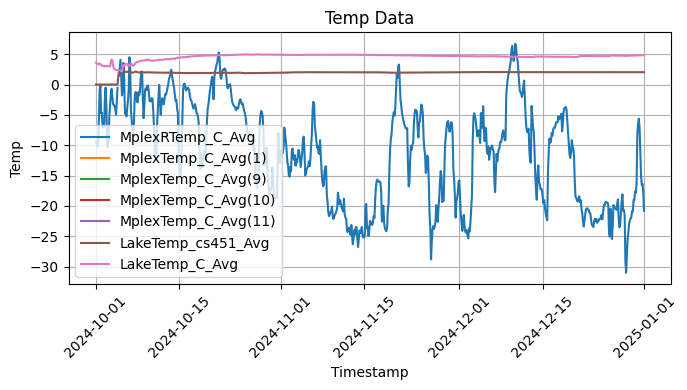

In [ ]:
qaqc_met = filtered_met.copy()

if metType in ['Hourly', 'Daily', 'FiveMinutes', 'ThreeHourly']:
  # Plot the temps
  plt.figure(figsize=(7, 4))  # Adjust figure size as needed
# 2. Check that all the temp sensors are in range of -60 to 37
  temp_cols = [col for col in qaqc_met.columns
               if "Temp" in col and "CNR" not in col and 'TMx' not in col and 'TMn' not in col]
  for col in temp_cols:
      # Convert the column to numeric, coercing errors to NaN
      qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors='coerce')
      qaqc_met.loc[~qaqc_met[col].between(-80, 60), col] = np.nan
      plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('Temp')
  plt.title('Temp Data')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

## Rain
Pay close attention here to rain2 values when its winter

**Variables:** Rain_mm_Tot (wyoming shield, measures year round precip, Rain2_mm_Tot

**Datasets:** Daily, Hourly

**QA/QC:** Rain_mm_Tot and Rain2_mm_Tot values < 0 change to NaN

Rain2_mm_Tot values that are > 0 in the winter (11, 12, 1, 2, 3, 4) change to 0.  
Change Rain2_mm_Tot values > 0 on negative days to NaN

 We will still need a manual check of days with naturalist journal if precip was recorded vs Rain_mm_Tot.

These sensors seem to have a lot of errors so pay attention to the graph output.

In [ ]:
if metType in ['Hourly', 'Daily']:
  plt.figure(figsize=(7, 4))  # Adjust figure size as needed
  #if start month is in winter (11,12, 1, 2, 3, 4) then change Rain2_m_Tot to 0
  precip_cols = [col for col in qaqc_met.columns if "Rain" in col]
  for col in precip_cols:
      # Convert the column to numeric, coercing errors to NaN
      qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
        # Filter for winter months (11, 12, 1, 2, 3, 4)
      winter_months_mask = qaqc_met['TIMESTAMP'].dt.month.isin([11, 12, 1, 2, 3, 4])
       # Change Rain2_mm_Tot to 0 for winter months
      qaqc_met.loc[winter_months_mask, 'Rain2_mm_Tot'] = 0
      qaqc_met.loc[qaqc_met[col] < 0, col] = np.nan


#convert Rain2_mm_Tot to NaN on non-winter month (5, 6, 7, 8, 9, 10) freezing days
  if 'Rain2_mm_Tot' in qaqc_met.columns and 'AirTemp_3m_Avg' in qaqc_met.columns:
      # Apply the temperture below where rain2 (rain precip) would be an error
      mask = (qaqc_met['Rain2_mm_Tot'] > 0) & (qaqc_met['AirTemp_3m_Avg'] <= 0)
      qaqc_met.loc[mask, 'Rain2_mm_Tot'] = np.nan
  for col in precip_cols:
    plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('Precip')
  plt.title('Precip Data')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
#display(qaqc_met[['TIMESTAMP', 'AirTemp_3m_Avg','Rain2_mm_Tot']])


  filtered_rows = qaqc_met[qaqc_met['Rain2_mm_Tot'] > 0]

 # Display the filtered rows
  display(filtered_rows[['TIMESTAMP','AirTemp_3m_Avg','Rain2_mm_Tot']])

plt.show();

## Relative Humidity
**Variables:** RH_3m_Avg and RH_5m_Avg

**Datasets:** Hourly and FiveMinutes

**QA/QC:** values of 100-105, change to 100. if > 105, change to NaN. Values < 0, change to 0

In [ ]:
if metType in ['Hourly', 'FiveMinutes']:
  plt.figure(figsize=(7, 4))  # Adjust figure size as needed
  rh_cols = [col for col in qaqc_met.columns if "RH" in col]
  for col in rh_cols:
      # Convert the column to numeric, coercing errors to NaN
      qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
      qaqc_met.loc[qaqc_met[col] < 0, col] = 0
      qaqc_met.loc[qaqc_met[col] > 105, col] = np.nan
      qaqc_met.loc[(qaqc_met[col] > 100) & (qaqc_met[col] <= 105), col] = 100
      plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('Relative Humidity')
  plt.title('Relative Humidity Data')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
#display(qaqc_met[['TIMESTAMP', 'AirTemp_3m_Avg','Rain2_mm_Tot']])
plt.show();

## Barometric Pressure
**Variables:** Press_mBar_Avg

**Datasets:** Hourly

**QA/QC:** Values < 850 change to NaN, graph to spot outliers

In [ ]:
if metType in ['Hourly']:
  col = 'Press_mBar_Avg'
  plt.figure(figsize=(7, 4))  # Adjust figure size as needed
  # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
  qaqc_met.loc[qaqc_met[col] < 850, col] = np.nan
  plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('Barometric Pressure')
  plt.title('Barometric Pressure Data')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
#display(qaqc_met[['TIMESTAMP', 'AirTemp_3m_Avg','Rain2_mm_Tot']])

# Calculate the quantiles
  lower_quantile = qaqc_met['Press_mBar_Avg'].quantile(0.0005)  # 0.05% quantile
  upper_quantile = qaqc_met['Press_mBar_Avg'].quantile(0.9995)  # 99.95% quantile

# Filter for outliers
  outliers = qaqc_met[
      (qaqc_met['Press_mBar_Avg'] < lower_quantile) | (qaqc_met['Press_mBar_Avg'] > upper_quantile)
  ]

  # Display the outliers
  print(outliers[['TIMESTAMP', 'Press_mBar_Avg']])
#if we decide that outliers should be removed, do this manually or we need to add a batch of code for this
plt.show();

## Windspeeds

**Variables:** WS_5m_5103_Max, WS_5m_5103_Avg, WS_5m_5106_Max, WS_5m_5106_Avg, WS_5m_sonic_Max, WS_5m_sonic_Avg, mean_wind_speed_5m_5103, mean_wind_speed_5m_5106, mean_wing_speed_5m_sonic

**Datasets:** Daily, Hourly, FiveMinutes

**QA/QC:** wind speeds should be within a range of 0-30 m/s, Graph to spot outliers. std and dir should be filtered where the wind rows are.

Remove flatlines in sonics (WS_5m_sonic_Max, WS_5m_sonic_Avg, mean_wing_speed_5m_sonic, mean_wing_direction_5m_sonic, std_wind_dir_sonic

In [ ]:
if metType in ['Daily', 'Hourly', 'FiveMinutes']:
  # Plot the wind speed and look for outliers or flatlines
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed

  # Define relevant column lists
  wind_cols = [col for col in qaqc_met.columns
               if any(keyword in col.lower() for keyword in ["wind", "ws", "wing"])
               and "dir" not in col.lower() and "std" not in col.lower()
               and 'tmx' not in col.lower() and 'tmn' not in col.lower()] # Exclude dir and std
  dir_std_cols = [col for col in qaqc_met.columns if "dir" in col] # Include dir and std

  for wind_col in wind_cols:
      # Convert the wind column to numeric, coercing errors to NaN
      qaqc_met[wind_col] = pd.to_numeric(qaqc_met[wind_col], errors='coerce')

      # Store original NaN mask for the current wind column if there are any NaN
      original_nan_mask = qaqc_met[wind_col].isna()
      # Apply wind speed range check
      qaqc_met.loc[~qaqc_met[wind_col].between(0, 30), wind_col] = np.nan
      # Get new NaN mask after applying wind speed range check
      new_nan_mask = qaqc_met[wind_col].isna()
      # Find timestamps where wind speed was changed to NaN
      changed_to_nan_mask = ~original_nan_mask & new_nan_mask

      # Change corresponding dir_std values to NaN
      if changed_to_nan_mask.any():  # Check if any values changed to NaN
          # Find related dir_std columns for the current wind column
          related_dir_std_cols = [col for col in dir_std_cols if wind_col.split('_')[0] in col]
          qaqc_met.loc[changed_to_nan_mask, related_dir_std_cols] = np.nan

      plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[wind_col], label=wind_col)
  plt.xlabel('Timestamp')
  plt.ylabel('Wind Speed (m/s)')
  plt.title('Wind Speed Data')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

In [ ]:
#now we check for flatlines: area where sonic columns go unchanged for more than 3 rows.
#change these to NaN. This is done for wing speed, direction, and std, WS_5m_sonic_Max, WS_5m_sonic_Avg
indices_to_replace = []
if metType in ['Hourly', 'Daily', 'FiveMinutes']:
  sonic_cols = [col for col in qaqc_met.columns if "sonic" in col
                and 'TMx' not in col and 'TMn' not in col]
  for col in sonic_cols:
    # Convert the column to numeric, coercing errors to NaN
    qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors='coerce')
        # Find the indices where the value does not change for 3 periods or more
    for i in range(2, len(qaqc_met)):
      if qaqc_met[col].iloc[i] == qaqc_met[col].iloc[i-1] == qaqc_met[col].iloc[i-2]:
        indices_to_replace.append(i)
    # Replace values at those indices with NaN
    qaqc_met.loc[indices_to_replace, col] = np.nan
#display( qaqc_met[['TIMESTAMP', 'mean_wing_speed_5m_sonic', 'mean_wing_direction_5m_sonic', 'std_wind_dir_sonic']])

In [ ]:
# check the wind direction columns are within 0-360 and if not change to NaN %%
if metType in ['Hourly', 'FiveMinutes']:
  wind_dir_cols = [col for col in qaqc_met.columns if "direction" in col]
  for col in wind_dir_cols:
      # Convert the column to numeric, coercing errors to NaN
      qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
      qaqc_met.loc[~qaqc_met[col].between(0, 360), col] = np.nan

## Lake Sensors

### LakeTemp
**Variables:** LakeTemp_C_Avg, LakeTemp_cs451_C_Avg, LakeTemp_C_Avg

**Datasets:** ThreeHourly

**QA/QC:** Values of all within range of -40 to 30

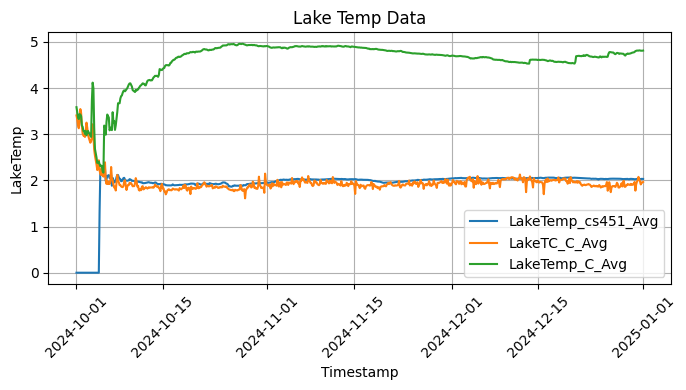

In [ ]:
if metType in ['ThreeHourly']:
  # Plot the temps
  plt.figure(figsize=(7, 4))  # Adjust figure size as needed
  LakeT_cols = [col for col in qaqc_met.columns if "LakeT" in col]
  for col in LakeT_cols:
    # Convert the column to numeric, coercing errors to NaN
    qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
    qaqc_met.loc[~qaqc_met[col].between(-40, 30), col] = np.nan
    plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('LakeTemp')
  plt.title('Lake Temp Data')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

### Lake Level sensor
**Variables:** LakeLvl_cm_Avg

**Datasets:** ThreeHourly

**QA/QC:** values within a range of 250 to 400

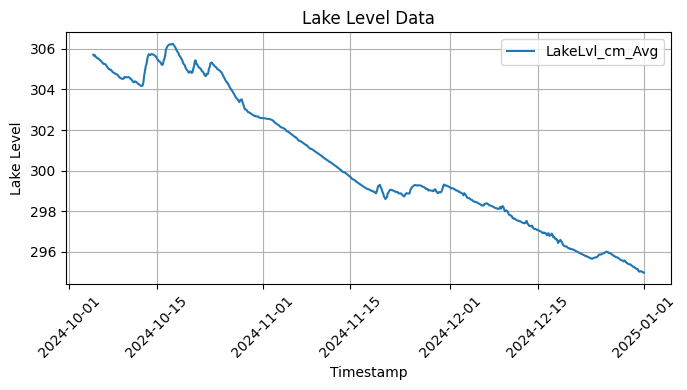

In [ ]:
if metType in ['ThreeHourly']:
  # Plot the temps
  plt.figure(figsize=(7, 4))  # Adjust figure size as needed
  col = 'LakeLvl_cm_Avg'
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
  qaqc_met.loc[~qaqc_met[col].between(250, 400), col] = np.nan
  plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('Lake Level')
  plt.title('Lake Level Data')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

## Seasonally removed sensors

UPDATE THE INSTALLATION AND REMOVAL DATES IN EACH ONE!
- LakeQuant_Avg
- Evap_Depth
- UVA_YES_AVG and UVB_YES_AVG
- BF5_total_AVG and BF5_diffuse_AVG

### Lake Quantity
The lake PAR

**Variables:** LakeQuant_Avg

**Datasets:** Hourly

**QA/QC:** Seasonally removed change to NaN

< 0 replace with 0, > 400 replae with NaN


In [ ]:
LakeQuant_installation_date = pd.to_datetime('2024-06-24')
LakeQuant_removal_date = pd.to_datetime('2024-10-01')

if metType in ['Hourly']:
  # Plot the Lake levels outliers
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  col = 'LakeQuant_Avg'
      # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
      #values below 0 change to 0, values above 400 change to NaN, change values to NaN if they fall after LakeQuant_removal_date
  qaqc_met.loc[qaqc_met[col] < 0, col] = 0  # Change values below 0 to 0
  qaqc_met.loc[qaqc_met[col] > 400, col] = np.nan # Change values above 400 to NaN
  qaqc_met.loc[(qaqc_met['TIMESTAMP'] < LakeQuant_installation_date) | (qaqc_met['TIMESTAMP'] >= LakeQuant_removal_date), col] = np.nan


  if qaqc_met['LakeQuant_Avg'].isnull().all():
      plt.text(0.5, 0.5, "Lake level sensor removed",
              horizontalalignment='center', verticalalignment='center',
              transform=plt.gca().transAxes, fontsize=12, color='red')
  else:
      plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
      plt.xlabel('Timestamp')
      plt.ylabel('Lake PAR')
      plt.title('Lake level data from Hourly')
      plt.legend()
      plt.grid(True)
      plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
      plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show();

### Evap Pan

**Variables:** Evap_Depth

**Datasets:** ThreeHourly

**QA/QC:** seasonally removed

In [ ]:
evapPan_installation_date = pd.to_datetime('2024-09-22')
evapPan_removal_date = pd.to_datetime('2024-06-20')

if metType in ['ThreeHourly']:
  col = 'Evap_Depth'
  # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
  qaqc_met.loc[(qaqc_met['TIMESTAMP'] < evapPan_installation_date) | (qaqc_met['TIMESTAMP'] >= evapPan_removal_date), col] = np.nan


### UVA and UVB
Total irradience at two wavelengths, owned by Rose Cory

**Variables:** UVA_YES_Avg, UVB_Yes_Avg

**Datasets:** Hourly, FiveMinutes

**QA/QC:** seasonally removed.

UVB's range is 0-2, < 0 change to 0; NaN if over.

UVA's range is 0-50, < 0 change to 0; NaN if over.

In [ ]:
UVAB_installation_date = pd.to_datetime('2024-04-25')
UVAB_removal_date = pd.to_datetime('2024-09-30')

if metType in ['Hourly', 'FiveMinutes']:
  UV_cols =[col for col in qaqc_met.columns if "UV" in col]
  for col in UV_cols:
    qaqc_met.loc[(qaqc_met['TIMESTAMP'] < UVAB_installation_date) | (qaqc_met['TIMESTAMP'] >= UVAB_removal_date), col] = np.nan
  col = 'UVA_YES_Avg'
  # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
      #values below 0 change to 0, values above 50 change to NaN
  qaqc_met.loc[qaqc_met[col] < 0, col] = 0
  qaqc_met.loc[qaqc_met[col] > 50, col] = np.nan

  col = 'UVB_YES_Avg'
  # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
      #values below 0 change to 0, values above 2 change to NaN
  qaqc_met.loc[qaqc_met[col] < 0, col] = 0
  qaqc_met.loc[qaqc_met[col] > 2, col] = np.nan

### BF5
**Variables:** BF5_total_Avg, BF5_diffuse_Avg

**Datasets:** Hourly, FiveMinutes

**QA/QC:** Seasonally removed.

< 0 replace with 0

In [ ]:
BF5_installation_date = pd.to_datetime('2024-04-25')
BF5_removal_date = pd.to_datetime('2024-09-30')

if metType in ['Hourly', 'FiveMinutes']:
  BF5_cols =[col for col in qaqc_met.columns if "BF5" in col]
  for col in BF5_cols:
    qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
    qaqc_met.loc[qaqc_met[col] < 0, col] = 0
    qaqc_met.loc[(qaqc_met['TIMESTAMP'] < BF5_installation_date) | (qaqc_met['TIMESTAMP'] >= BF5_removal_date), col] = np.nan



## Solar sensors
- SolarkW_Avg
- Quant_Avg
- CNR4_SW_UP_Avg
- CNR4_SW_DN_Avg
- CNR4_LW_DN_Avg
- Rnet_Avg
- albedo_Avg
All are in Hourly and 5 Min

###SolarkW_Avg
Solar kW_Avg is total solar radiation with a spectral range of 310 to 2800nm. Units are in kW/m2

**Variables:** SolarkW_Avg

**Datasets:** Hourly, FiveMinutes

**QA/QC:** < 0 replace with 0. > 880 change to NaN



In [ ]:
if metType in ['Hourly', 'FiveMinutes']:
  col = 'SolarkW_Avg'
  # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
  qaqc_met.loc[qaqc_met[col] < 0, col] = 0
  qaqc_met.loc[qaqc_met[col] > 880, col] = np.nan

###Quant_Avg
Normal PAR

**Variables:** Quant_Avg

**Datasets** Hourly

**QA/QC:** Check within the range of 0 to 1700. Values < 0 change to 0


In [ ]:
if metType in ['Hourly', 'FiveMinutes']:
  col = 'Quant_Avg'
  # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
  qaqc_met.loc[qaqc_met[col] < 0, col] = 0
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.plot(qaqc_met['TIMESTAMP'], qaqc_met['Quant_Avg'], label='Quant_Avg')
  plt.xlabel('Timestamp')
  plt.ylabel('Quant_Avg')
  plt.title('Quant_Avg')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

### CNR4
These are shortwave or longwave pyranometers looking up and down.

**Variables:** CNR4_SW_UP_Avg, CNR$_SW_DN_Avg, CNR4_LW_UP_corr_Avg, CNR4_LW_Dn_corr_Avg

**Datasets:** Hourly, FiveMinutes

**QA/QC:** All CNR4s have a range of 0 to 900. If < 0, replace with 0. If > 900, replace with NaN

In [ ]:
if metType in ['Hourly', 'FiveMinutes']:
  CNR4_cols =[col for col in qaqc_met.columns if "CNR4" in col]
  for col in CNR4_cols:
    qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
    qaqc_met.loc[qaqc_met[col] < 0, col] = 0
    qaqc_met.loc[qaqc_met[col] > 900, col] = np.nan
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[CNR4_cols], label=CNR4_cols)
  plt.xlabel('Timestamp')
  plt.ylabel('CNR4')
  plt.title('CNR4')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show();

###Rnet_Avg
Net radiation from CNR4 sensors

**Variables:** Rnet_Avg

**Datasets:** Hourly, FiveMinutes

**QA/QC:** Range is -250 to 750. This needs a graph to spot outliers.

In [ ]:
import matplotlib.ticker as ticker
if metType in ['Hourly', 'FiveMinutes']:
  qaqc_met['Rnet_Avg'] = pd.to_numeric(qaqc_met['Rnet_Avg'], errors = 'coerce')
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.plot(qaqc_met['TIMESTAMP'], qaqc_met['Rnet_Avg'], label='Rnet_Avg')
  plt.xlabel('Timestamp')
  plt.ylabel('Rnet_Avg')
  plt.title('Rnet_Avg vs. Timestamp')
  plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(25))
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

  #If somethng looks high and you want to ID where it is.. or chang it to NaN
#filtered_rows = qaqc_met[qaqc_met['Rnet_Avg'] < -70]

 # Display the filtered rows
#display(filtered_rows)

  #Change rows that are outliers to NaN
#aqc_met.loc[qaqc_met['Rnet_Avgl] < -250, 'Rnet_Avg'] = np.nan



### Albedo_Avg
Albedo from CNR4 sensors

**Variables:** albedo_Avg

**Datasets:** Hourly, FiveMinutes

**QA/QC:** The range is 0-1. < 0 and > 1 replace with NaNs.

In [ ]:
if metType in ['Hourly', 'FiveMinutes']:
  col = 'albedo_Avg'
  # Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
  qaqc_met.loc[qaqc_met[col] < 0, col] = np.nan
  qaqc_met.loc[qaqc_met[col] > 1, col] = np.nan

## Soil Temp
- VWC(1), VWC (2)
- shf_Avg(1), shf_Avg(2), shf_Avg(3), shf_Avg(4)
- Tsoil_Avg(1), Tsoil_Avg(2)



### VWC
**Variables:** VWC(1), VWC (2)

**Datasets:** Hourly

**QA/QC:** Range 0-1; Remove when Tsoil1 is < 0C

In [ ]:
if metType in ['Hourly']:
  VWC_cols =[col for col in qaqc_met.columns if "VWC" in col]
  for col in VWC_cols:
    qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
    qaqc_met.loc[~qaqc_met[col].between(0, 1), col] = np.nan
 # Replace VWC(1) values when Tsoil_Avg(1) is less than 0
  qaqc_met['Tsoil_Avg(1)'] = pd.to_numeric(qaqc_met['Tsoil_Avg(1)'], errors='coerce')
  qaqc_met.loc[qaqc_met['Tsoil_Avg(1)'] < 0, 'VWC(1)'] = np.nan
  qaqc_met['Tsoil_Avg(2)'] = pd.to_numeric(qaqc_met['Tsoil_Avg(2)'], errors='coerce')
  qaqc_met.loc[qaqc_met['Tsoil_Avg(2)'] < 0, 'VWC(2)'] = np.nan

### shf_Avg
**Variables:** shf_Avg(1), shf_Avg(2), shf_Avg(3), shf_Avg(4)

**Datasets:** Hourly

***QA/QC:** graph all the SHF varaibles, they can vary widley. They should all look similar. Spot outliers

In [ ]:
if metType in ['Hourly']:
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  shf_cols =[col for col in qaqc_met.columns if "shf" in col]
  for col in shf_cols:
    qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')

    plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('shf')
  plt.title('shf vs. Timestamp')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

  #If somethng looks high and you want to ID where it is.. or chang it to NaN
#filtered_rows = qaqc_met[qaqc_met[shf_cols] < -70]

 # Display the filtered rows
#display(filtered_rows)

  #Change rows that are outliers to NaN
#aqc_met.loc[qaqc_met['Rnet_Avgl] < -250, 'Rnet_Avg'] = np.nan

### Tsoil_Avg
**Variables:** Tsoil_Avg(1), Tsoil_Avg(2), soil2_moss_Avg, soil2_5cm_Avg, soil2_10cm_Avg, soil2_20cm_Avg, soil2_50cm_Avg, soil2_100cm_Avg, soil2_150cm_Avg, soil1_moss_Avg, soil1_20cm_Avg, soil1_150cm_Avg, soil1_5cm_Avg, , soil1_10cm_Avg, soil1_50cm_Avg, soil1_100cm_Avg,

**Datasets:** Hourly, ThreeHourly

**QA/QC:** Within a range of -10 to 30, replace with NaN if outside.

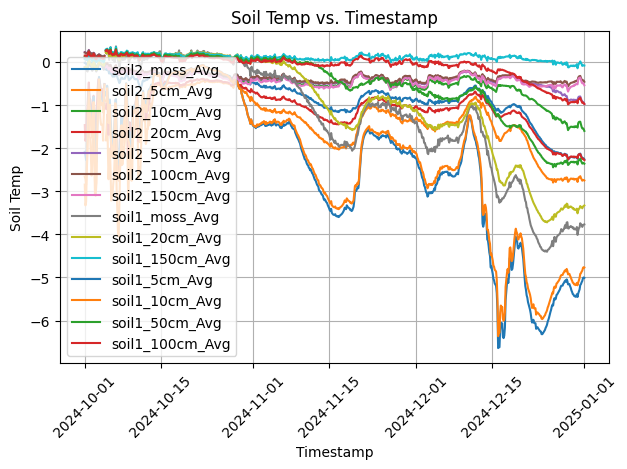

In [ ]:
if metType in ['Hourly', 'ThreeHourly']:
  tsoil_cols =[col for col in qaqc_met.columns if "soil" in col]
  for col in tsoil_cols:
    qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
    qaqc_met.loc[~qaqc_met[col].between(-10, 30), col] = np.nan
    plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('Soil Temp')
  plt.title('Soil Temp vs. Timestamp')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

## Snow Depth
**Variable:** Snow_Dpeth

**Datasets:** Hourly

**QA/QC:** shift up or down based on lowest June value or a field calibration.

Convert to cm

*The last adjustment was +0.046m*

In [ ]:
if metType in ['Hourly']:
  col = 'Snow_Depth'
  #Convert the column to numeric, coercing errors to NaN
  qaqc_met[col] = pd.to_numeric(qaqc_met[col], errors = 'coerce')
  #shift up or down based on lowest June value
  qaqc_met[col] = qaqc_met[col] + 0.046
  #convert to cm
  qaqc_met[col] = qaqc_met[col] * 100
  qaqc_met.loc[qaqc_met[col] < 0, col] = np.nan
  display(qaqc_met['Snow_Depth'].head(5))
  plt.plot(qaqc_met['TIMESTAMP'], qaqc_met[col], label=col)
  plt.xlabel('Timestamp')
  plt.ylabel('Snow Depth')
  plt.title('Snow Depth vs. Timestamp')
  plt.legend()
  plt.grid(True)
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show();

#Format the final file
- add back the second row of units
- change na.nap values to string "NaN"

In [ ]:
#add rowOne_replace into the qaqc_met file as row one and adjust the index
# Concatenate rowOnedf and qaqc_met vertically
final_met = pd.concat([rowOne, qaqc_met], ignore_index=True)

#fill the missing data with string "NaN"
final_met = final_met.fillna("NaN")

#if the file is FiveMintes change the column header 'CNR4_LW_UP_corr_Avg' to 'LW_UP_Avg_5min' and 'CNR4_LW_DN_corr_Avg' to 'LW_DN_Avg_5min'
if metType in ['Fiveminutes']:
  #replace column title CNR4_LW_Up_corr with LW_Up_Avg_5min
  #replace CNR4_LW_DN_Corr with LW_Dn_Avg_5mnin
  qaqc_met.rename(columns={'CNR4_LW_Up_corr': 'LW_Up_Avg_5min', 'CNR4_LW_Dn_corr': 'LW_Dn_Avg_5min'}, inplace=True)

# SAVE YOUR OUTPUT FILE! Still you should visually check the data.

Especially rain_mm!!

In [ ]:
#download your file!
filename = f"TFS_Met_CR3000_{metType}_{calendar.month_abbr[start_date.month]}-{calendar.month_abbr[end_date.month]}_{start_date.year}_QAQC.xlsx" #adjust your dates here
final_met.to_excel(filename, index=False)
#save the file somewhere else or download it from files in colab. Colab will delete the file if you leave it here.
from google.colab import files
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fix notes
-std_wind_dir_5130 and std_wind_dir_5106 aren't qa/qcd in any way. the only qa/qc needed is to filter when mean_wind is altered

- volt in ThreeHourly is capitalized
-date times are formated differently. does that matter?